### SIGNATE_COVID-19_最適化モデル

#### モデル概要

    １．SIGNATEの提供する、累積感染者数　と　日々の感染者数を使用し　新規の感染者数（＋累積感染者数）を求める。
    既存感染者数と、感染者から新規感染が起こる、接触頻度に関係する　特性値を元に　数学モデルを作る。
    ２．感染者数データはばらついており、特に曜日による変動が大きいので、７日の移動平均を元にモデルを構築する。
    ３．考え方
    　①新規感染者数（PCR検査結果が陽性になり集計後発表された数字）の、感染元の数は　N日前に発表された感染者数に依存すると考える。
     
      ②接触頻度はM日前の接触頻度特性値に依存すると考える。
      接触頻度特性として渋谷駅周辺の昼間の人の数を利用したが、この値は感染予防に向けた意識、努力の程度を代表値として表しているのであって、渋谷が特別な場所ではないと考える。
      接触頻度は、５月連休明けまでは、agoop社が提供している、渋谷駅周辺の人の密度データを加工して使用した。
      https://corporate-web.agoop.net/pdf/covid-19/agoop_analysis_coronavirus.pdf
      https://corona.go.jp/toppage/pdf/area-transition/20200516_agoop.pdf
      5/15からは段階的に接触頻度が増加し、４月のどの時期レベルまで戻るかを想定し接触頻度特性値を作成した。
      （４月中旬レベル、４月５日前後、４月１日前後レベルの３種）
       
      ③それぞれ（①②）は単純比例ではなく累乗の係数を考え　全部で５個のパラメータで表せるモデルを考える。
      ④既存のデータを用い誤差が最小となるパラメータを探す。モデルの数式は以下の通り。
    
    
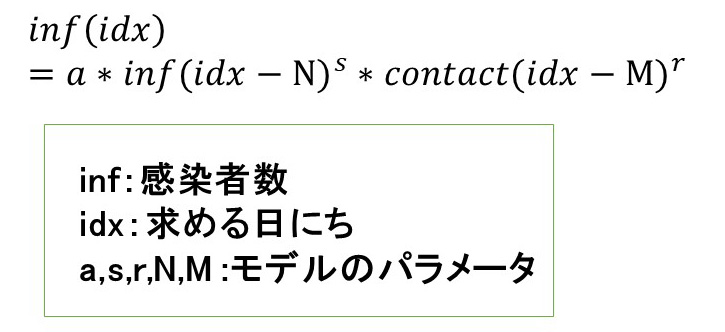

In [1]:
import os
import numpy as np
import pandas as pd

from pulp import *

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error


import datetime
import time

import warnings
warnings.filterwarnings("ignore")


### 使用する　データ（SIGNATE_COVID19 .csv)の　読み込み　前処理
　SIGNATEが提供する　累計感染者数（T_PCR_p）、新規感染者数（PCR_p）、接触特性を読み込む
 ７日間の移動平均を計算する　

In [32]:
#　T_PCR_p：pcr検査で＋となった人数（累計）、PCR_p：新規
#　sibuya_○○○○：接触頻度特性（渋谷の人の密度）　5/15以降戻るレベルごとに３種

original_data_path = "./DATA/"
data_path=original_data_path + 'SIGNATE_COVID19 .csv'

SIG_All = pd.read_csv(data_path)

print('SIGNATE_COVID19 .shape',SIG_All.shape)

SIG_All[80:140]

SIGNATE_COVID19 .shape (167, 6)


,date,T_PCR_p,PCR_p,sibuya_0415,sibuya_0405,sibuya_0401
80,2020/4/5,3865.0,358.0,0.4739,0.4739,0.4739
81,2020/4/6,4109.0,244.0,0.4462,0.4462,0.4462
82,2020/4/7,4477.0,368.0,0.4215,0.4215,0.4215
83,2020/4/8,5003.0,526.0,0.4002,0.4002,0.4002
84,2020/4/9,5581.0,578.0,0.3824,0.3824,0.3824
85,2020/4/10,6225.0,644.0,0.3678,0.3678,0.3678
86,2020/4/11,6945.0,720.0,0.3565,0.3565,0.3565
87,2020/4/12,7452.0,507.0,0.3454,0.3454,0.3454
88,2020/4/13,7757.0,305.0,0.3347,0.3347,0.3347
89,2020/4/14,8237.0,480.0,0.3254,0.3254,0.3254


In [33]:
# 移動平均による平滑化

SIG_All['T_PCR_p_MAve']=SIG_All['T_PCR_p'].rolling(7).sum()/7 #累積感染者の計算
SIG_All['PCR_p_MAve']=SIG_All['PCR_p'].rolling(7).sum()/7     #新規感染者の計算

SIG_All['sibuya_0415_MAve']=SIG_All['sibuya_0415'].rolling(7).sum()/7
SIG_All['sibuya_0405_MAve']=SIG_All['sibuya_0405'].rolling(7).sum()/7
SIG_All['sibuya_0401_MAve']=SIG_All['sibuya_0401'].rolling(7).sum()/7

40 :  2020/2/25
60 :  2020/3/16
80 :  2020/4/5
100:  2020/4/25
120:  2020/5/15
140:  2020/6/4


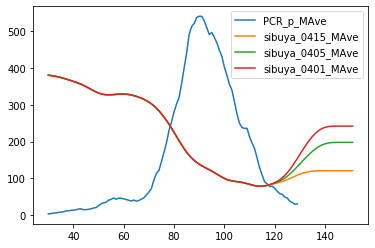

In [34]:
# 感染者数　および　接触頻度特性（３種）の移動平均の表示　
print('40 : ',SIG_All['date'].loc[40])
print('60 : ',SIG_All['date'].loc[60])
print('80 : ',SIG_All['date'].loc[80])
print('100: ',SIG_All['date'].loc[100])
print('120: ',SIG_All['date'].loc[120])
print('140: ',SIG_All['date'].loc[140])

DF_plot=SIG_All.copy()

DF_plot=DF_plot[['PCR_p_MAve','sibuya_0415_MAve','sibuya_0405_MAve','sibuya_0401_MAve']][30:152]

DF_plot['sibuya_0415_MAve']=DF_plot['sibuya_0415_MAve']*400
DF_plot['sibuya_0405_MAve']=DF_plot['sibuya_0405_MAve']*400
DF_plot['sibuya_0401_MAve']=DF_plot['sibuya_0401_MAve']*400

DF_plot.plot()

In [35]:
# 以下　モデルの計算、計算結果の保存用のデータフレーム
DF=SIG_All.copy()
DF[125:135]

,date,T_PCR_p,PCR_p,sibuya_0415,sibuya_0405,sibuya_0401,T_PCR_p_MAve,PCR_p_MAve,sibuya_0415_MAve,sibuya_0405_MAve,sibuya_0401_MAve
125,2020/5/20,16480.0,39.0,0.2661,0.3119,0.3578,16375.000000,47.142857,0.242157,0.265600,0.289043
126,2020/5/21,16518.0,38.0,0.2742,0.3303,0.3853,16413.285714,38.285714,0.249486,0.280071,0.310500
127,2020/5/22,16543.0,25.0,0.2813,0.3486,0.4128,16448.000000,34.714286,0.257157,0.295900,0.334043
128,2020/5/23,16569.0,26.0,0.2875,0.3670,0.4404,16478.285714,30.285714,0.264886,0.312800,0.359243
129,2020/5/24,16603.0,34.0,0.2926,0.3853,0.4679,16509.714286,31.428571,0.272371,0.330471,0.385657
130,2020/5/25,NaN,NaN,0.2966,0.4037,0.4954,NaN,NaN,0.279314,0.348629,0.412843
131,2020/5/26,NaN,NaN,0.2997,0.4220,0.5199,NaN,NaN,0.285429,0.366971,0.439929
132,2020/5/27,NaN,NaN,0.3017,0.4383,0.5413,NaN,NaN,0.290514,0.385029,0.466143
133,2020/5/28,NaN,NaN,0.3028,0.4526,0.5596,NaN,NaN,0.294600,0.402500,0.491043
134,2020/5/29,NaN,NaN,0.3028,0.4648,0.5749,NaN,NaN,0.297671,0.419100,0.514200


### 　感染者データの移動平均データを使い　モデルのパラメータを求める
####   　５つのパラメータを少しづつ変化させ正解値との差がminになる組み合わせを探す。　

####      　モデルのパラメータを求め　第一次予測を行う　
    新規感染者  ：　PCR_p_MAve(idx）　＝　係数(a)　X　感染者項　X　接触頻度項
    感染者項　   :　PCR_p_MAve(idxーN)＾ｓ
    接触頻度項　 :　sibuya（idxーM)＾ｒ


In [36]:
# 新規感染者数を推測するモデルを学習させるクラス

optim_num=20000    # 最適化計算をする回数 

X_list=np.array([[0,20, 0.6 , 5.910],[10,20 , 1.5 , 11],[8,30, 1.5, 13],[-1,10, 0.4 , 1.8705],[-1,10,0.4,0.84210]])
   # 最適化するパラメータ[a,N,M,r,s] の　範囲（最小、最大）と刻み、初期値
     
column_list=['PCR_p_MAve','sibuya_0405_MAve','inf_MAve']  # データフレーム中　使用する変数
#　最後のリストは予測値を入れる列

idx_last=129    # 最適化に使用するデータの最小値
idx_start=80    #                         最大値 

class Optimizer:
    def __init__(self,
                 DF = DF,                 # 使用するデータフレーム　idxで値を呼び出す
                 X_list=X_list,            #  最適化する　パラメータ
                 idx_last=idx_last,        #  学習に使用する最終idx
                 idx_start=idx_start,      #　学習に使用する最初のidx
                 column_list=column_list,  #　使用する　列名リスト
                 optim_num=optim_num       #  学習回数
                 ):
        
        self.DF=DF
        self.X_list=X_list
        self.idx_start=idx_start
        self.idx_last=idx_last
        self.column_list=column_list
        self.optim_num=optim_num
        
    def Pred_y(self,X,idx):  # 予測モデル X:モデルのパラメータ　idx：求める日にちに相当
        inf = ((self.DF[self.column_list[0]].loc[idx-X[1]]+
                self.DF[self.column_list[0]].loc[idx-X[1]-1])+
               self.DF[self.column_list[0]].loc[idx-X[1]-2]/3)**X[4]  # 感染者数　項(変動大きいので３日分の平均)
        cont = self.DF[self.column_list[1]].loc[idx-X[2]]**X[3]       # 接触頻度　項
        Pred_y = X[0] * inf * cont
    
        return Pred_y
    
    def calc_loss(self,X):    # 指定範囲のデータを用いてモデルの予測誤差を計算
        loss=0
        for idx in range(self.idx_start,self.idx_last):
            T=self.DF[self.column_list[0]].loc[idx]  # 正解
            P = self.Pred_y(X,idx)                   # 予測値
            loss += np.abs(T-P)
            #loss += np.square(T-P)
        return loss/(self.idx_last-self.idx_start)
    
    def X_valid(self,X): # 乱数により　X　の値を制約の中でシフトさせ　新たなXを発生させる
        rand=(np.random.rand(len(self.X_list)) -0.5)*2      # -1～1の乱数を５個発生
        dx=X_list[:,2]*rand                              # Xの変化幅
        dx[1:3]=np.round(dx[1:3])                        # 整数値が必要な項目の処理 
        X=X+dx                                           # 差分を元のXに加える
        X=np.clip(X,self.X_list[:,0],self.X_list[:,1])   #  X_listで定義された最大最小値内にクリップ
        return X
    
    def closing(self,X):    # 終了処理　最終モデルの予測データの保存　グラフ化
        self.DF[self.column_list[2]]='NaN'
        for idx in range(self.idx_start,self.idx_last+int(min(X[1],X[2]))):# 学習済みモデルで予測・保存
            P = self.Pred_y(X,idx)
            self.DF[self.column_list[2]].loc[idx]=P
            
        DF_plot=self.DF[self.column_list].loc[self.idx_start:self.idx_last]
        DF_plot[self.column_list[1]]=DF_plot[self.column_list[1]]*500
        DF_plot.plot()
        return self.DF
        
        
    def optim(self):         # 最適化処理　loss　minとなるパラメータを探す
        X=self.X_list[:,3]#　初期値
        X_min=X
        loss_min=self.calc_loss(X)
        for i in range(self.optim_num):
            if i%5000==0:
                print('loss',loss_min,X_min,i)
            X=self.X_valid(X_min)
            loss = self.calc_loss(X)
            if loss<loss_min :
                X_min=X
                loss_min=loss
                #print('loss',loss,X,i)
        DF = self.closing(X_min)
        print('')
        print('loss',loss_min,X_min)
        return X_min , DF
            

loss 18.47564833309244 [ 5.91   11.     13.      1.8705  0.8421] 0
loss 13.854360413695646 [ 4.28818165 10.         10.          1.87664651  0.9192475 ] 5000
loss 12.551496110829552 [ 4.47156354 10.         10.          2.01511601  0.930767  ] 10000
loss 10.967940187743912 [ 5.60724864 10.         10.          1.87891337  0.88227107] 15000

loss 10.967940187743912 [ 5.60724864 10.         10.          1.87891337  0.88227107]
Wall time: 2min 20s


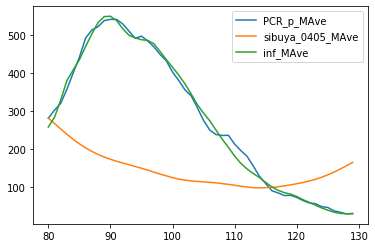

In [37]:
%%time
# クラスを使い　モデルのパラメータを学習させる

Opti=Optimizer()
optim_X,DF00=Opti.optim()



In [38]:
DF00[125:135]

,date,T_PCR_p,PCR_p,sibuya_0415,sibuya_0405,sibuya_0401,T_PCR_p_MAve,PCR_p_MAve,sibuya_0415_MAve,sibuya_0405_MAve,sibuya_0401_MAve,inf_MAve
125,2020/5/20,16480.0,39.0,0.2661,0.3119,0.3578,16375.000000,47.142857,0.242157,0.265600,0.289043,40.0359
126,2020/5/21,16518.0,38.0,0.2742,0.3303,0.3853,16413.285714,38.285714,0.249486,0.280071,0.310500,34.754
127,2020/5/22,16543.0,25.0,0.2813,0.3486,0.4128,16448.000000,34.714286,0.257157,0.295900,0.334043,31.7519
128,2020/5/23,16569.0,26.0,0.2875,0.3670,0.4404,16478.285714,30.285714,0.264886,0.312800,0.359243,30.5885
129,2020/5/24,16603.0,34.0,0.2926,0.3853,0.4679,16509.714286,31.428571,0.272371,0.330471,0.385657,30.8681
130,2020/5/25,NaN,NaN,0.2966,0.4037,0.4954,NaN,NaN,0.279314,0.348629,0.412843,31.3086
131,2020/5/26,NaN,NaN,0.2997,0.4220,0.5199,NaN,NaN,0.285429,0.366971,0.439929,30.8915
132,2020/5/27,NaN,NaN,0.3017,0.4383,0.5413,NaN,NaN,0.290514,0.385029,0.466143,30.0504
133,2020/5/28,NaN,NaN,0.3028,0.4526,0.5596,NaN,NaN,0.294600,0.402500,0.491043,30.1212
134,2020/5/29,NaN,NaN,0.3028,0.4648,0.5749,NaN,NaN,0.297671,0.419100,0.514200,30.2369


### 学習したパラメータを用い　予測を行う　
####  ５月末に　4/15　レベルの接触頻度に戻ることを想定


In [10]:
# 学習したパラメータを入れたモデルを用い　感染者数の移動平均を予測する
#　　学習に用いた日にちより後の予測を行う
column_list[1]='sibuya_0415_MAve'    # 使用する接触頻度特性

pred_last = 165 # 予測を行う　最終行数

Opti=Optimizer(DF=DF00)   # 新たなデータでクラスを立ち上げ直す
for idx in range(idx_last-1,pred_last):
    DF00['inf_MAve'].loc[idx]=Opti.Pred_y(optim_X,idx)    # 予測結果を保存
    DF00['PCR_p_MAve'].loc[idx]=Opti.Pred_y(optim_X,idx)  #　予測結果を予測に使う列に追加

#DF00[130:165]

80 :  2020/4/5
100 :  2020/4/25
120:  2020/5/15
140:  2020/6/4
160:  2020/6/24


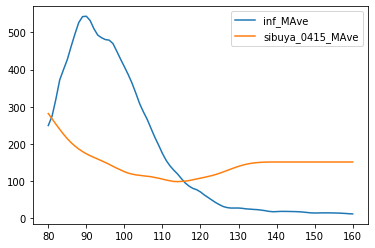

In [11]:
#　新規感染者数の予測結果と　使用した接触頻度特性を表示
print('80 : ',DF00['date'].loc[80])
print('100 : ',DF00['date'].loc[100])
print('120: ',DF00['date'].loc[120])
print('140: ',DF00['date'].loc[140])
print('160: ',DF00['date'].loc[160])

DF_plot=DF00[['inf_MAve',column_list[1]]].loc[idx_start:160]
DF_plot[column_list[1]]=DF_plot[column_list[1]]*500

DF_plot.plot()

### 学習したパラメータを用い　予測を行う　
####  ５月末に　4/5　レベルの接触頻度に戻ることを想定

#####  いったん　新規感染者数は減少するが　再び増加する結果となる。

In [26]:
# 学習したパラメータを入れたモデルを用い　感染者数の移動平均を予測する
#　　学習に用いた日にちより後の予測を行う
column_list[1]='sibuya_0405_MAve'    # 使用する接触頻度特性

pred_last = 165 # 予測を行う　最終行数

Opti=Optimizer(DF=DF00)   # 新たなデータでクラスを立ち上げ直す
for idx in range(idx_last-1,pred_last):
    DF00['inf_MAve'].loc[idx]=Opti.Pred_y(optim_X,idx)    # 予測結果を保存
    DF00['PCR_p_MAve'].loc[idx]=Opti.Pred_y(optim_X,idx)  #　予測結果を予測に使う列に追加

80 :  2020/4/5
100 :  2020/4/25
120:  2020/5/15
140:  2020/6/4
160:  2020/6/24


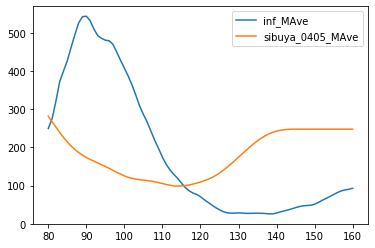

In [27]:
#　結果を表示
print('80 : ',DF00['date'].loc[80])
print('100 : ',DF00['date'].loc[100])
print('120: ',DF00['date'].loc[120])
print('140: ',DF00['date'].loc[140])
print('160: ',DF00['date'].loc[160])

DF_plot=DF00[['inf_MAve',column_list[1]]].loc[idx_start:160]
DF_plot[column_list[1]]=DF_plot[column_list[1]]*500

DF_plot.plot()

In [12]:
#DF00[130:156]

### 　予測した移動平均データを、各曜日に対応したデータに戻す
    ５月連休までの曜日ごとの変動特性を求め、移動平均に重み付けを行う。
    この特性は、医療機関等の曜日ごとの処理量の変動の処理であり、人為的なものである。
    処理フロー等が変われば変更が必要

In [16]:
#  感染者数を入れる列の追加
DF00['inf']='NaN'
DF00['T_inf']=DF00['T_PCR_p']

In [17]:
# 移動平均から各曜日の値に戻す関数
monday_idx=74     # 月曜日のidx
coef_list=[0.593, 0.9237, 1.081, 1.112, 1.189 ,1.199, 0.851]   # 曜日ごとの係数
week=['月','火','水','木','金','土','日']

def calc_inf_num(idx):
    week_idx = (idx-monday_idx)% 7
    #print(week_idx)
    #print(week[week_idx])
    val=DF00['PCR_p_MAve'].loc[idx+3]*coef_list[week_idx]
    return val


303.92857142857144

80 :  2020/4/5
100 :  2020/4/25
120:  2020/5/15
140:  2020/6/4


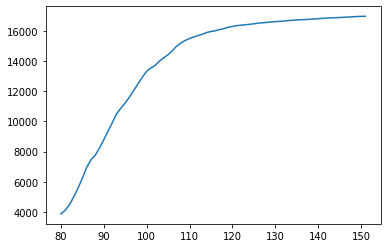

In [20]:
#  元に戻す関数を使用し　感染者数の移動平均から 新規感染者数　累積感染者数を求める

lastID=152              # この処理を行う最後の行番号
last_T_PCR_p=idx_last+1 # 累計計算のスタート点  最後の累計計測値データ

for idx in range(idx_start,lastID):
    DF00['inf'].loc[idx]=int(calc_inf_num(idx))

#  感染者数の累積を計算する  
DF00['T_inf'].loc[last_T_PCR_p]=DF00['T_PCR_p'].loc[last_T_PCR_p]   

for idx in range(idx_last+1,lastID):
    DF00['T_inf'].loc[idx]=DF00['T_inf'].loc[idx-1]+DF00['inf'].loc[idx]
    
#  感染者数の累積を表示する   
print('80 : ',DF00['date'].loc[80])
print('100 : ',DF00['date'].loc[100])
print('120: ',DF00['date'].loc[120])
print('140: ',DF00['date'].loc[140])

DF_plot=DF00['T_inf'].loc[idx_start:lastID-1]
DF_plot.plot()